In [182]:
from easypip import easyimport, easyinstall, is_notebook
easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

[easypip] Installing bbrl_gymnasium>=0.2.0
[easypip] Installing bbrl_gymnasium[box2d]
[easypip] Installing bbrl_gymnasium[classic_control]


In [183]:
import os
import sys
from pathlib import Path
import math
import numpy as np

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime

from gymnasium import Env, Space, Wrapper, make

from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
from bbrl.workspace import Workspace
from bbrl.agents import Agents, TemporalAgent
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video
from bbrl.utils.replay_buffer import ReplayBuffer

import torch.nn as nn

from typing import Tuple
from bbrl.agents.gymnasium import make_env, GymAgent, ParallelGymAgent
from functools import partial

from bbrl import instantiate_class

import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from IPython.display import clear_output

import cv2
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten

import random as python_random
import tensorflow as tf

In [184]:
# Utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

In [234]:
SEED = 42

# Memes parametres que dans les notebooks, pour le moment on y touche pas mais a changer apres peut etre
param={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-buffer-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": SEED,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 2,
    "n_steps": 32,
    "n_updates": 32,
    "eval_interval": 2000,
    "learning_starts": 2000,
    "nb_evals": 10,
    "buffer_size": 1e6,
    "batch_size": 256,
    "target_critic_update": 5000,
    "max_epochs": 100, #MAX ITER 
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [64, 64]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 1e-3,
  }
}

config=OmegaConf.create(param)

TEST AVEC UN RANDOM AGENT

In [186]:
# meme randomAgent que dans les notebooks
class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim
        self.all_observations = []

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)
        self.all_observations.append(obs)


In [187]:
# on extend le parallelGymAgent pour pouvoir obtenir l'environment des agents
# finalement y pas eu besoin apres donc on peut changer ca mais on fera apres 
# A CHANGER A PRIORI C'EST PLUS UTILE ICI
class CustomParallelGymAgent(ParallelGymAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def get_my_attribute(self):
        return self.envs

In [188]:
#un des agents les plus importants:
#on utilise le CustomParallelGymAgent pour obtenir l'environment d'un agent puis on extrait les informations
#notamment l'image du cartpole a chaque temps t
#avec cette image, on la preprocess et on la passe dans un cnn (defini plus bas)
class AttributeAccessAgent(Agent):
    def __init__(self, env_agent, pre_processing_agent, cnn_agent):
        super().__init__()
        #les agents
        self.env_agent = env_agent  # CustomParallelGymAgent ou ParallelGymAgent
        self.pre_processing_agent = pre_processing_agent
        self.cnn_agent = cnn_agent
        #init de la liste de listes pour store les images
        self.list_images = [[] for _ in range(self.env_agent.num_envs)]
        self.list_features = [[] for _ in range(self.env_agent.num_envs)]
    
    def forward(self, t: int, **kwargs):
        #print('Currently at time ', t)
        #ici on fait le forward pour chaque agent (donc en fonction du nombre d'environments)
        for env_index in range(self.env_agent.num_envs):
            image = self.env_agent.envs[env_index].render() #on recupere l'image
            display = False #pour afficher en temps reel mais pas utile pour +1 env
            if display: #print a chaque temps l'image originale
                clear_output(wait=True)   
                plt.imshow(image)  
                plt.axis('off')
                plt.show()
                print("Displayed image at time", t, " of agent ", env_index)
            #print(image.shape)
            
            image_pre_processed = self.pre_processing_agent.preprocess(image) #image renvoyee pas le preprocesseur

            self.list_images[env_index].append(image_pre_processed) #on ajoute au bon endroit dans la liste

            # attention a bien mettre l'image preprocessed ici sinon y a des pb avec le cnn
            features = self.cnn_agent.process_image(image_pre_processed) 
            #print(features.shape)
            self.list_features[env_index].append(features) #on ajoute pareil pour les features
    def get_features(self, t):
        if t < len(self.list_features[0]):
            tensor = self.list_features[0][t]
            #print(type(tensor))
            return tensor
        else:
            # Handle the case where the tensor does not exist
            print(f"Features for timestep {t} are not available.")
            return None

In [189]:
# agent pour gerer le preprocessing, rien de trop particulier
# on pourrait faire du preprocessing plus complexe si jamais on obtient des mauvais resultats
class PreProcessingAgent(Agent):
    def __init__(self):
        super().__init__()

    def preprocess(self, image):
        processed_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  #on mets en noir et blanc
        processed_image = cv2.resize(processed_image, (224, 224))  #on rescale 
        return processed_image #image de taille (224, 224)

In [190]:
#modele CNN: c'est une implementation plutot basqiue de cnn, truc classique qu'on trouve sur internet
#on fait avec 5 layers pcq a priori ca devrait suffire
TENSRSIZE = 32
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16 x 112 x 112
            
            #layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32 x 56 x 56
            
            #layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 28 x 28
            
            #layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 14 x 14
            
            #layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256 x 7 x 7
        )
        
        self.fc_layers = nn.Sequential( #on cherche a avoir un vecteur de taille 128 (une ligne)
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, TENSRSIZE),  
        )
        
    def forward(self, x): #ici c'est l'image qui a ete converti en tensor
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [191]:
# l'agent cnn qui implemente le modele cnn defini en haut
class CNNAgent(Agent):
    def __init__(self):
        super().__init__()
        self.cnn = CNN() #le cnn

    def process_image(self, image):
        #on converti l'image (preprocessed) en un tensor qu'on peut mettre dans le cnn
        #taille [1, 1, 224, 224], batch_size, channels, height, width
        image_tensor = torch.tensor(image, dtype=torch.float).unsqueeze(0).unsqueeze(0)  
        image_tensor = image_tensor / 255.0   #petite normalisation

        with torch.no_grad(): #on calcule pas le gradient (a voir si on le fait apres)
            features = self.cnn(image_tensor)
        features = features.cpu().numpy()
        return torch.tensor(features) #on renvoie le vecteur


In [192]:
#petite fonction pour afficher toutes les etapes d'une execution d'un agent dans un environement
def displayImagesPerAgent(images_per_agent):
    n_cols = 4  # nb de colonnes avec des images a afficher
    
    for env_index, images in enumerate(images_per_agent):
        print(f"Environment {env_index + 1}:")
        n_images = len(images)
        n_rows = (n_images + n_cols - 1) // n_cols  #nb de lignes

        #trucs a changer pour l'affichage mais pas beosin d'y toucher je pense
        figsize_width = 10  
        figsize_height = n_rows * (figsize_width / n_cols) * 0.5 
        plt.figure(figsize=(figsize_width, figsize_height))

        for i, image in enumerate(images):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(image)
            plt.axis('off')  
        
        plt.tight_layout()
        plt.show()

Donzo got all images
Environment 1:


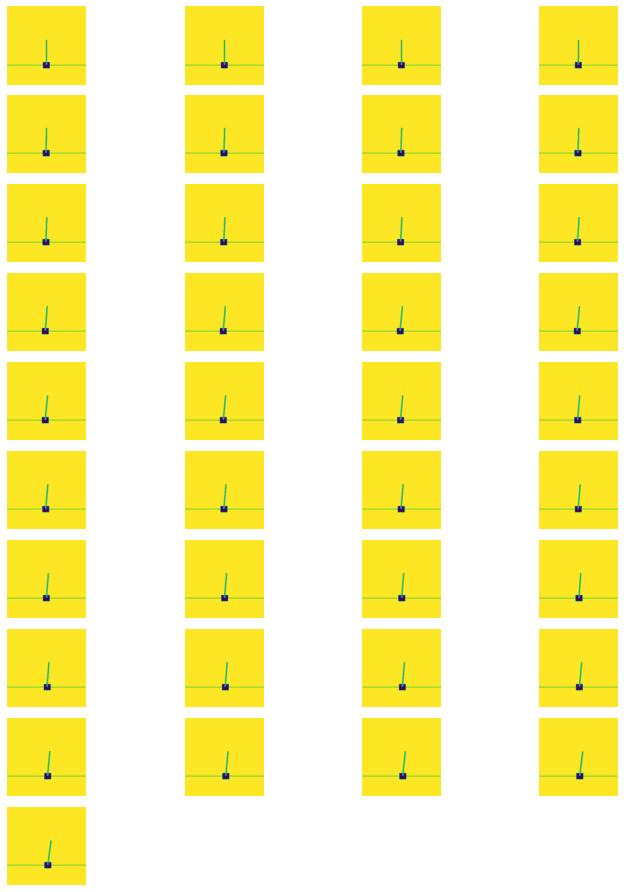

Environment 2:


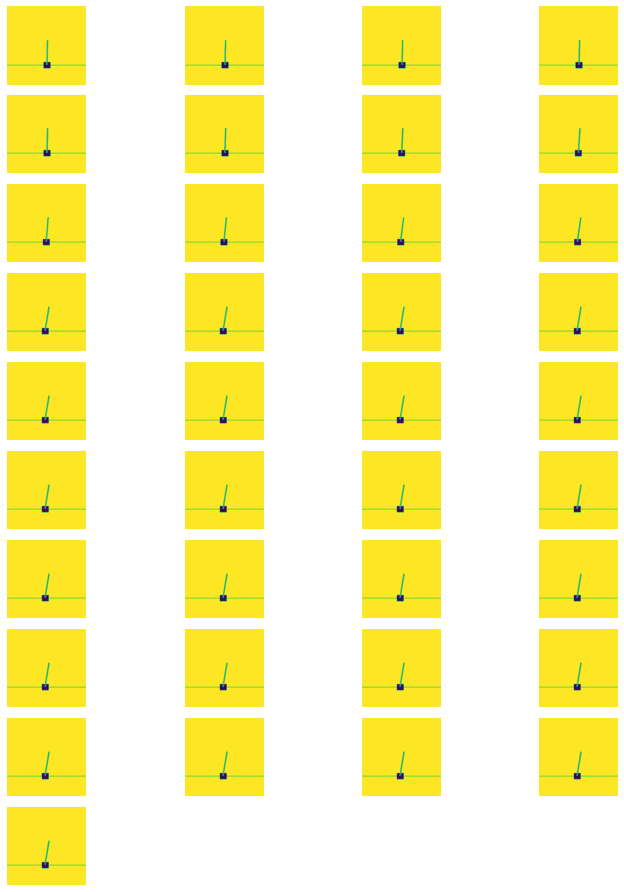

<class 'torch.Tensor'>


In [235]:
workspace = Workspace()
nb_env = 2 #changer le nombre d'environements qu'on veut ici
action_dim = 2 #vaudrait mieux prednre depuis le parallelgymagent mais ca va jamais changer ici
autoreset = False #pour le moment pouor le simplifier la vie
pre_processing_agent = PreProcessingAgent()
cnn_agent = CNNAgent()

im_env_agent = CustomParallelGymAgent(partial(make_env, config.gym_env.env_name, render_mode="rgb_array", autoreset=autoreset), nb_env).seed(SEED)
attribute_access_agent = AttributeAccessAgent(im_env_agent, pre_processing_agent, cnn_agent)
agents = Agents(im_env_agent, RandomAgent(action_dim), attribute_access_agent)
t_agents = TemporalAgent(agents)


t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)
images = attribute_access_agent.list_images 
print('Donzo got all images')
displayImagesPerAgent(images)
print(type(attribute_access_agent.get_features(0))) #to retrieve the tensor at time 0

OK ON VA ESSAYER DE FAIRE UN AGENT DQN MAINTENANT

In [221]:
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    """Helper function to build a multi-layer perceptron (function from $\mathbb R^n$ to $\mathbb R^p$)
    
    Args:
        sizes (List[int]): the number of neurons at each layer
        activation (nn.Module): a PyTorch activation function (after each layer but the last)
        output_activation (nn.Module): a PyTorch activation function (last layer)
    """
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

#QUAND UN BUILD LE MLP FAUT QUE sizes SOIT DU TYPE [128, 64, 2]
#ex: mlp = build_mlp(sizes=[128] + [64, 64] + [2], activation=nn.ReLU(), output_activation=nn.Identity())

In [222]:
class DiscreteQAgent(Agent):
    def __init__(self, input_dim, hidden_layers, action_dim, attribute_access_agent):
        super().__init__()
        self.model = build_mlp(
            [input_dim] + list(hidden_layers) + [action_dim], 
            activation=nn.ReLU()
        )
        # Store the reference to AttributeAccessAgent to access the features
        self.attribute_access_agent = attribute_access_agent

    def forward(self, t: int, choose_action=True, **kwargs):
        # Retrieve the current feature vector for time step t from AttributeAccessAgent
        current_features = self.attribute_access_agent.get_features(t)
        #print("obs ", current_features)
        
        # Assume current_features is a tensor; if not, convert it to a tensor
        q_values = self.model(current_features)
        self.set(("q_values", t), q_values)

        if choose_action:
            action = q_values.argmax(dim=1)
            self.set(("action", t), action)

In [223]:
class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t: int, **kwargs):
        # Retrieves the q values 
        # (matrix nb. of episodes x nb. of actions)
        q_values = self.get(("q_values", t))
        size, nb_actions = q_values.size()

        # Flag 
        is_random = torch.rand(size).lt(self.epsilon).float()
        random_action = torch.randint(low=0, high=nb_actions, size=(size,))
        max_action = q_values.max(1)[1]

        # Choose the action based on the is_random flag
        action = is_random * random_action + (1 - is_random) * max_action

        # Sets the action at time t
        self.set(("action", t), action.long())
        self.epsilon = max(0.001, self.epsilon * 0.995)


In [224]:
from bbrl import instantiate_class

class Logger():

    def __init__(self, cfg):
        self.logger = instantiate_class(cfg.logger)

    def add_log(self, log_string, loss, steps):
        self.logger.add_scalar(log_string, loss.item(), steps)

    # A specific function for RL algorithms having a critic, an actor and an entropy losses
    def log_losses(self, critic_loss, entropy_loss, actor_loss, steps):
        self.add_log("critic_loss", critic_loss, steps)
        self.add_log("entropy_loss", entropy_loss, steps)
        self.add_log("actor_loss", actor_loss, steps)

    def log_reward_losses(self, rewards, nb_steps):
        self.add_log("reward/mean", rewards.mean(), nb_steps)
        self.add_log("reward/max", rewards.max(), nb_steps)
        self.add_log("reward/min", rewards.min(), nb_steps)
        self.add_log("reward/median", rewards.median(), nb_steps)

In [225]:
# For the tensor dimensions
# T = maximum number of time steps
# B = number of episodes run in parallel 
# A = state space dimension

def compute_critic_loss(cfg, reward: torch.Tensor, must_bootstrap: torch.Tensor, q_values: torch.Tensor, action: torch.LongTensor):
    q_values_for_actions = q_values.gather(2, action.unsqueeze(-1)).squeeze(-1)
    
    # Compute the max Q-value for the next state, but not for the last timestep
    next_q_values = q_values[1:].max(dim=2)[0]
    # Compute the expected Q-values (target) for the current state and action
    target_q_values = reward[:-1] + cfg["algorithm"]["discount_factor"] * next_q_values * must_bootstrap[:-1]
    
    # Compute the loss as the mean squared error between the current and target Q-values
    loss = F.mse_loss(q_values_for_actions[:-1], target_q_values)
    
    return loss

In [226]:
# Configure the optimizer over the q agent
def setup_optimizer(cfg, q_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = q_agent.parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer

In [251]:
#bit messy here but ill fix it later
#creating the dqn agent
pre_processing_agent = PreProcessingAgent()
cnn_agent = CNNAgent()
workspace = Workspace()

def get_env_agents(cfg):
    print(cfg.algorithm.n_envs)
    train_env_agent = CustomParallelGymAgent(partial(make_env, cfg.gym_env.env_name, render_mode="rgb_array", autoreset=False), 
                                        cfg.algorithm.n_envs).seed(cfg.algorithm.seed)
    eval_env_agent = CustomParallelGymAgent(partial(make_env, cfg.gym_env.env_name, render_mode="rgb_array"), 
                                        cfg.algorithm.n_envs).seed(cfg.algorithm.seed)
    print("success get_env_agents")
    return train_env_agent, eval_env_agent

def create_dqn_agent(cfg, train_env_agent, eval_env_agent):
    attribute_access_train = AttributeAccessAgent(train_env_agent, pre_processing_agent, cnn_agent)
    attribute_access_eval = AttributeAccessAgent(eval_env_agent, pre_processing_agent, cnn_agent)


    critic = DiscreteQAgent(TENSRSIZE, cfg.algorithm.architecture.hidden_size, 2, attribute_access_train)

    #training
    q_agent = TemporalAgent(critic)
    explorer = EGreedyActionSelector(cfg.algorithm.epsilon)
    tr_agent = Agents(train_env_agent, attribute_access_train, critic, explorer)
    train_agent = TemporalAgent(tr_agent)

    #eval
    ev_agent = Agents(eval_env_agent, attribute_access_eval, critic)
    eval_agent = TemporalAgent(ev_agent)
    print("success create_dqn_agent")
    return train_agent, eval_agent, q_agent


In [244]:
def run_dqn(cfg):
    # 1)  Build the  logger
    logger = Logger(cfg)
    best_reward = float('-inf')

    # 2) Create the environment agent
    train_env_agent, eval_env_agent = get_env_agents(cfg)
    
    # 3) Create the DQN Agent
    train_agent, eval_agent, q_agent = create_dqn_agent(
        cfg, train_env_agent, eval_env_agent
    )

    # Note that no parameter is needed to create the workspace.
    # In the training loop, calling the train_agent
    # will take the workspace as parameter

    # 6) Configure the optimizer
    optimizer = setup_optimizer(cfg, q_agent)
    nb_steps = 0
    tmp_steps = 0
    nb_measures = 0
    
    while nb_measures < 200: #cfg.algorithm.nb_measures
        train_workspace = Workspace()

        # Run 
        train_agent(train_workspace, t=0, stop_variable="env/done", stochastic=True)

        q_values, done, truncated, reward, action = train_workspace[
            "q_values", "env/done", "env/truncated", "env/reward", "action"
        ]

        nb_steps += len(action.flatten())
        
        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj
        must_bootstrap = torch.logical_or(~done, truncated)
        
        # Compute critic loss
        critic_loss = compute_critic_loss(cfg, reward, must_bootstrap, q_values, action)

        # Store the loss for tensorboard display
        logger.add_log("critic_loss", critic_loss, nb_steps)

        optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            q_agent.parameters(), cfg.algorithm.max_grad_norm
        )
        optimizer.step()

        if nb_steps - tmp_steps > cfg.algorithm.eval_interval:
            nb_measures += 1
            tmp_steps = nb_steps
            eval_workspace = Workspace()  # Used for evaluation
            eval_agent(
                eval_workspace, t=0, stop_variable="env/done", choose_action=True
            )
            rewards = eval_workspace["env/cumulated_reward"][-1]
            mean = rewards.mean()
            logger.add_log("reward", mean, nb_steps)
            print(f"nb_steps: {nb_steps}, reward: {mean}")
            if cfg.save_best and mean > best_reward:
                best_reward = mean
                directory = "./dqn_critic/"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                filename = directory + "dqn_" + str(mean.item()) + ".agt"
                eval_agent.save_model(filename)
                
    return train_agent, eval_agent, q_agent

In [255]:
params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-simple-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 3,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 1,
    "n_steps": 32,
    "eval_interval": 2000,
    "nb_measures": 200,
    "nb_evals": 10,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [128, 128]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 2e-3,
  }
}

In [256]:
import sys
import os
import os.path as osp
print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={os.getcwd()}/tblogs")

cfg=OmegaConf.create(params)
torch.manual_seed(cfg.algorithm.seed)
train_agent, eval_agent, q_agent = run_dqn(cfg)

Launch tensorboard from the shell:
c:\Users\titouan\anaconda3/tensorboard --logdir=c:\Users\titouan\OneDrive\Bureau\SORBONNE S2\PLDAC_BBRL\src/tblogs
1
success get_env_agents
success create_dqn_agent
nb_steps: 2008, reward: 9.0


KeyboardInterrupt: 